# Chercher les capitaines dans les deux jeux de données


## Librairies utilisées

* String Grouper
  * https://pypi.org/project/string-grouper/
  * N'est pas disponible sous Conda ! Cf. la problématique Pip—Conda !
  * Créer un environnement dédié et installer d'abord toutes les dépendances généres par Conda dont la principale est scikit-learn 
* Levenshtein
  * https://maxbachmann.github.io/Levenshtein/levenshtein.html




In [6]:
import pandas as pd
from string_grouper import match_strings, match_most_similar, \
    group_similar_strings, compute_pairwise_similarities, \
     StringGrouper

In [8]:
import Levenshtein as lv

In [9]:
import os
import sqlite3 as sql
import plotly.express as px
import plotly.io as pio

In [10]:
pio.renderers.default = "jupyterlab"

In [11]:
csd = os.getcwd()
print(csd)

/home/francesco/shared_files/python_notebooks/SD_for_HSS/Cycle-Data/2-mashup/fb


In [12]:
os.chdir('/home/francesco/shared_files/python_notebooks/SD_for_HSS/Cycle-Data')

In [13]:
tt = pd.read_csv('./1-dataviz_tools/netherlands.csv')

In [41]:
os.chdir('/home/francesco/shared_files/python_notebooks/SD_for_HSS/Cycle-Data/2-mashup/fb')

In [14]:
len(tt), tt.head()

(1909,
   Flag of vessel Date vessel departed with captives          Vessel name  \
 0    Netherlands               1732-09-03T00:00:00Z            Waartwijk   
 1    Netherlands               1706-09-09T00:00:00Z        Wakende Kraan   
 2    Netherlands               1706-09-09T00:00:00Z        Wakende Kraan   
 3    Netherlands                                NaN  Wapen van Amsterdam   
 4    Netherlands                                NaN  Wapen van Amsterdam   
 
         Captain's name  
 0    Velde, Daniel ter  
 1  Hoeven, Jan van der  
 2       Wenman, Roelof  
 3                  NaN  
 4       Scheij, Pieter  )

In [15]:
tt.columns = ['flag','date_departed', 'name', 'captain']

tt.head()

,flag,date_departed,name,captain
0,Netherlands,1732-09-03T00:00:00Z,Waartwijk,"Velde, Daniel ter"
1,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Hoeven, Jan van der"
2,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Wenman, Roelof"
3,Netherlands,NaN,Wapen van Amsterdam,NaN
4,Netherlands,NaN,Wapen van Amsterdam,"Scheij, Pieter"


In [16]:
tts = ''.join(sorted(tt['name'][3].lower().split()))
print(tts)

amsterdamvanwapen


In [19]:
### https://www.statology.org/levenshtein-distance-in-python/
t1 = 'amsterdamwapen'
lv.distance(tts, t1)

3

In [20]:
tt=tt.fillna('')
tt.head()

,flag,date_departed,name,captain
0,Netherlands,1732-09-03T00:00:00Z,Waartwijk,"Velde, Daniel ter"
1,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Hoeven, Jan van der"
2,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Wenman, Roelof"
3,Netherlands,,Wapen van Amsterdam,
4,Netherlands,,Wapen van Amsterdam,"Scheij, Pieter"


In [21]:
tt.isna()

,flag,date_departed,name,captain
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
1904,False,False,False,False
1905,False,False,False,False
1906,False,False,False,False
1907,False,False,False,False


In [22]:
tt[tt["name"].str.contains('Wapen van Amsterdam')]

,flag,date_departed,name,captain
3,Netherlands,,Wapen van Amsterdam,
4,Netherlands,,Wapen van Amsterdam,"Scheij, Pieter"
937,Netherlands,1663-04-28T00:00:00Z,Wapen van Amsterdam,"Nuchteren, Jan Gerritsen"
938,Netherlands,1663-04-28T00:00:00Z,Wapen van Amsterdam,"Ridder, Paulus Heijn"


In [23]:
'Hoeven, Jan van der'.replace(',', '').replace(' ', '')

'HoevenJanvander'

In [24]:
tt["captain_name_concat"] = tt["captain"].apply(lambda x : str(x).replace(',', '').replace(' ', ''))

In [25]:
tt.head()

,flag,date_departed,name,captain,captain_name_concat
0,Netherlands,1732-09-03T00:00:00Z,Waartwijk,"Velde, Daniel ter",VeldeDanielter
1,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Hoeven, Jan van der",HoevenJanvander
2,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Wenman, Roelof",WenmanRoelof
3,Netherlands,,Wapen van Amsterdam,,
4,Netherlands,,Wapen van Amsterdam,"Scheij, Pieter",ScheijPieter


In [26]:
len(tt)

1909

In [27]:
left = tt['captain_name_concat']
len(left)

1909

In [28]:
### Connection à la base de données SQLite
# Si elle n'existe pas elle est créée à la connection
db_address = '/home/francesco/shared_files/python_notebooks/SD_for_HSS/Cycle-Data/data/maritime_history.db'
cnn = sql.connect(db_address)

In [29]:
q = """with tw1 as (
SELECT (REPLACE(voyMasterLastName, '.', '') || REPLACE(voyMasterFirstName, '.', '')) name_rec , dv.voyDepartureEDTF, dv.voyArrivalDateEDTF 
FROM das_master dm, das_voyage dv 
WHERE dv.voyMasterID = dm.voyMasterID
ORDER BY dv.voyDepartureEDTF, dv.voyArrivalDateEDTF )
SELECT count(*) as eff, name_rec, (group_concat(SUBSTRING(voyDepartureEDTF, 1,4)  )) liste_dates
FROM tw1
WHERE name_rec IS NOT NULL
group by name_rec
order by eff DESC;
"""


In [30]:
lignes_table = pd.read_sql_query(q, cnn)
lignes_table.head()

,eff,name_rec,liste_dates
0,17,VisserPieter,"1719,1721,1724,1725,1733,1734,1736,1736,1738,1..."
1,16,VriesJakob,"1715,1717,1725,1725,1727,1728,1757,1759,1762,1..."
2,16,PietersenKornelis,"1762,1763,1763,1764,1765,1765,1766,1766,1767,1..."
3,14,WiebeJakob,"1746,1748,1749,1749,1750,1752,1754,1755,1759,1..."
4,13,WitJan,"1614,1690,1693,1695,1696,1699,1708,1709,1740,1..."


In [31]:
right = lignes_table["name_rec"]
right[:3], len(right)

(0         VisserPieter
 1           VriesJakob
 2    PietersenKornelis
 Name: name_rec, dtype: object,
 2972)

In [32]:
matched = match_strings(left,right, min_similarity = 0.7)
len(matched), matched

(193,
      left_index left_captain_name_concat  similarity     right_name_rec  \
 0          1402          VerdoesBastiaan    1.000000    VerdoesBastiaan   
 1           703          AntheunissenJan    0.717786        HaanTheunis   
 2           702          AntheunissenJan    0.717786        HaanTheunis   
 3            37        HageropChristiaan    1.000000  HageropChristiaan   
 4            36        HageropChristiaan    1.000000  HageropChristiaan   
 ..          ...                      ...         ...                ...   
 188         292         BaaneJanCornelis    0.747947  BaaneJan Kornelis   
 189         291         BaaneJanCornelis    0.747947  BaaneJan Kornelis   
 190         290         BaaneJanCornelis    0.747947  BaaneJan Kornelis   
 191        1116            JanszLeendert    0.852089  AdriaanszLeendert   
 192         856             JanszAbraham    0.855898   AdriaanszAbraham   
 
      right_index  
 0             20  
 1             42  
 2             42  


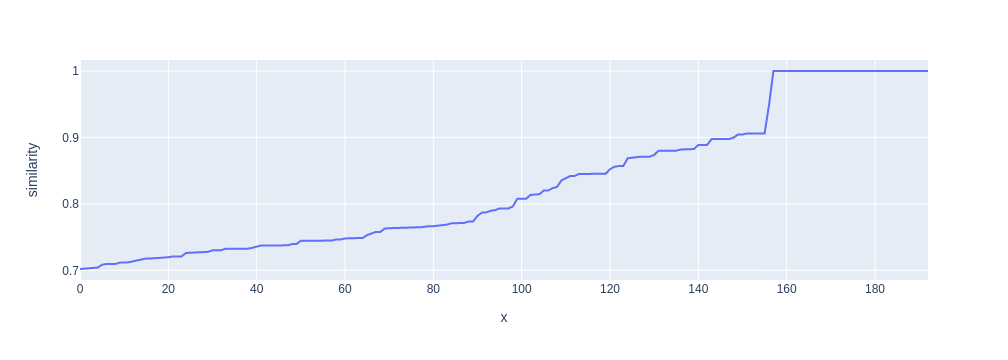

In [33]:
fig = px.line(matched.sort_values("similarity"), x =matched.index, y ='similarity')
fig.show()

In [34]:
matched[matched["similarity"] > 0.75].sort_values("similarity").head(30)

,left_index,left_captain_name_concat,similarity,right_name_rec,right_index
46,1116,JanszLeendert,0.752968,JakobszLeendert,807
18,1358,BrestJan,0.755783,EstJan,344
147,1833,MichielszMichiel,0.757811,KorneliszMichiel,2200
148,1818,MichielszMichiel,0.757811,KorneliszMichiel,2200
69,852,WoutersBartolomeus,0.762897,NoutersBartholomeus,1137
30,927,HarmenszGovert,0.763303,JanszGovert,514
58,1654,JanszGijsbert,0.763700,WillemszGijsbert,946
143,1818,MichielszMichiel,0.763937,MichielszJan,2032
142,1833,MichielszMichiel,0.763937,MichielszJan,2032
101,786,WiltonJan,0.764654,WiltonJohn,1518


In [35]:
matched[matched["similarity"] > 0.9].sort_values("similarity").head(30)

,left_index,left_captain_name_concat,similarity,right_name_rec,right_index
181,1205,BrasserMatthijsLaurensz,0.904395,BrasserMatthijs Laurentsz,2777
180,1432,BrasserMatthijsLaurensz,0.904395,BrasserMatthijs Laurentsz,2777
169,775,WoutmanFrederik,0.905909,HoutmanFrederik,2402
167,777,WoutmanFrederik,0.905909,HoutmanFrederik,2402
168,776,WoutmanFrederik,0.905909,HoutmanFrederik,2402
170,774,WoutmanFrederik,0.905909,HoutmanFrederik,2402
171,773,WoutmanFrederik,0.905909,HoutmanFrederik,2402
113,458,VeldeDanielde,0.948529,VeldeDaniel,1631
10,464,OutjesJochem,1.000000,OutjesJochem,186
26,1346,PropPieter,1.000000,PropPieter,446


In [43]:
matched = matched.sort_values("similarity", ascending=False)
matched.tail(30)

,left_index,left_captain_name_concat,similarity,right_name_rec,right_index
57,518,WolfJ,0.727777,WolfJohan,939
144,801,LuciferPieter,0.726829,LuciferHendrik,2085
125,964,HovenFrederikFrederikszvan,0.726297,RijksFrederik Frederiksz,1869
123,1695,HovenFrederikFrederikszvan,0.726297,RijksFrederik Frederiksz,1869
124,1228,HovenFrederikFrederikszvan,0.726297,RijksFrederik Frederiksz,1869
70,1831,JansenAdriaan,0.726102,KrijnsenAdriaan,1209
48,1749,DiemenseJan,0.720852,DiemenJan,865
47,1870,DiemenseJan,0.720852,DiemenJan,865
49,1733,DiemenseJan,0.720852,DiemenJan,865
119,34,SmitJan,0.719655,SmitJan Hendrik,1747


In [44]:
lv.jaro_winkler('BotPieter', 'BootPieter')

0.9733333333333334

In [45]:
export_file = './data/matched.csv'
matched.to_csv(export_file)